# Regressão Softmax com dados do MNIST

## Objetivo

O objetivo deste notebook é ilustrar o uso de praticamente a mesma rede desenvolvida para a classificação das flores Íris, porém agora com o problema de classificação de dígitos manuscritos utilizando o dataset MNIST.
As principais diferenças são:
- tipo do dado, agora imagem com muito atributos: 28 x 28 pixels
- número de amostras, muito maior, 60 mil
Neste exercício será possível a interpretação do significado dos parâmetros treinados

## Importação das bibliotecas

In [30]:
! pip install Pillow

In [31]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable

import torchvision

## Carregamento dos dados do MNIST

In [32]:
! git clone https://github.com/vcasadei/MNIST.git

fatal: destination path 'MNIST' already exists and is not an empty directory.


In [33]:
!ls MNIST

processed  raw


In [34]:
dataset_dir = 'MNIST/'

x_train, y_train = torch.load(dataset_dir + 'processed/training.pt')

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 60000

Dimensões dos dados das imagens:    torch.Size([60000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Carregamento, normalização e seleção dos dados do MNIST

Neste exemplo utilizaremos apenas 1000 amostras de treinamento.

In [35]:
x_train = x_train.float()

x_train = x_train / 255.

if True:
    n_samples_train = 1000 #Apenas para usar 1000 amostras, se caso for para usar tudo, colococar como false.

    x_train = x_train[:n_samples_train]
    y_train = y_train[:n_samples_train]

print("Amostras de treinamento:", x_train.size(0))

print("\nDimensões dos dados das imagens:   ", x_train.size())
print("Valores mínimo e máximo dos pixels:", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:        ", type(x_train))
print("Tipo das classes das imagens:      ", type(y_train))

Amostras de treinamento: 1000

Dimensões dos dados das imagens:    torch.Size([1000, 28, 28])
Valores mínimo e máximo dos pixels: tensor(0.) tensor(1.)
Tipo dos dados das imagens:         <class 'torch.Tensor'>
Tipo das classes das imagens:       <class 'torch.Tensor'>


### Visualizando os dados

(-0.5, 232.5, 87.5, -0.5)

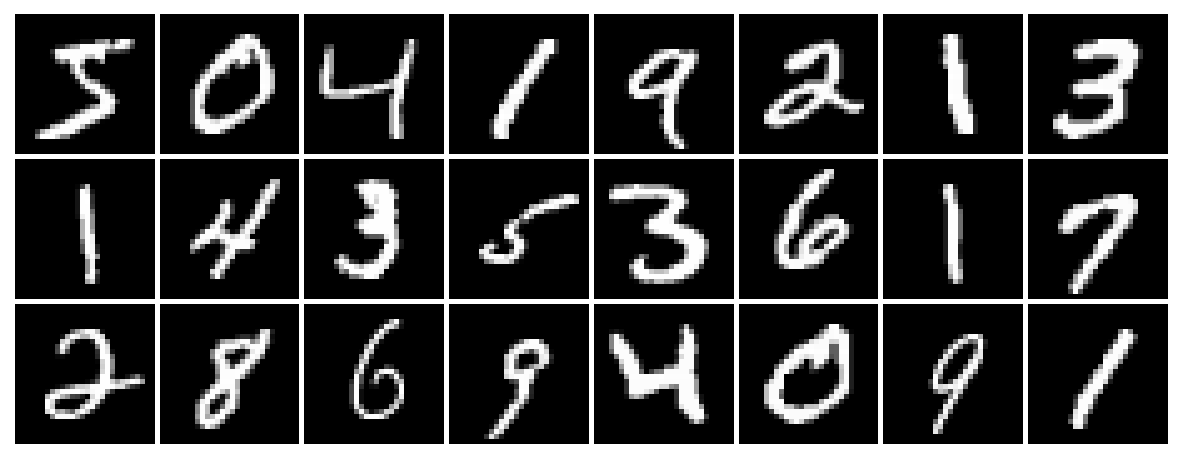

In [36]:
n_samples = 24

# cria um grid com as imagens
grid = torchvision.utils.make_grid(x_train[:n_samples].unsqueeze(dim=1), pad_value=1.0, padding=1)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off')

### Visualizando uma imagem com o matplotlib

class: tensor(5)


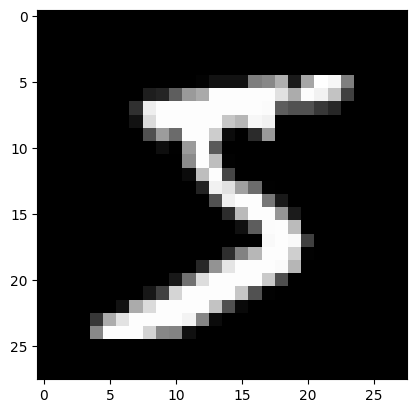

In [37]:
image  = x_train[0]
target = y_train[0]

plt.imshow(image.numpy(), cmap='gray')
print('class:', target)

## Modelo

In [38]:
model = torch.nn.Linear(28*28, 10) # 28*28 atributos de entrada e 10 neurônios na sáida

### Testando um predict com poucas amostras

In [39]:
xin = x_train[:5].view(-1,28*28)
score = model(Variable(xin))
score

tensor([[ 0.2161,  0.1496, -0.1508,  0.1465,  0.0213,  0.1486,  0.0935,  0.0203,
          0.0330, -0.1382],
        [ 0.0743,  0.1780, -0.0473,  0.2869, -0.0348,  0.0206, -0.1312, -0.1664,
         -0.0880, -0.4189],
        [-0.0134,  0.0403, -0.1678,  0.2558,  0.3815, -0.0790,  0.2741,  0.1125,
         -0.3008,  0.0573],
        [-0.0008,  0.2386, -0.1784, -0.0067,  0.2303,  0.1781,  0.2187, -0.0427,
         -0.0195,  0.0462],
        [-0.2190,  0.3075,  0.2025, -0.0599,  0.1901,  0.1131, -0.0272, -0.0696,
         -0.2092,  0.1430]], grad_fn=<AddmmBackward0>)

In [40]:
xin

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Quantidade de parâmetros = 28x28x10 + 10 = 7850

In [41]:
import torch.nn.functional as F
F.softmax(score, dim=1)*100

tensor([[11.6818, 10.9303,  8.0940, 10.8964,  9.6144, 10.9195, 10.3344,  9.6047,
          9.7278,  8.1967],
        [10.9440, 12.1397,  9.6910, 13.5376,  9.8127, 10.3720,  8.9116,  8.6029,
          9.3050,  6.6834],
        [ 9.1471,  9.6518,  7.8383, 11.9722, 13.5763,  8.5665, 12.1939, 10.3741,
          6.8623,  9.8176],
        [ 9.2664, 11.7725,  7.7587,  9.2120, 11.6756, 11.0815, 11.5405,  8.8861,
          9.0945,  9.7121],
        [ 7.6290, 12.9156, 11.6283,  8.9446, 11.4856, 10.6344,  9.2422,  8.8588,
          7.7040, 10.9574]], grad_fn=<MulBackward0>)

## Treinamento

### Inicialização dos parâmetros

In [42]:
epochs = 100
learningRate = 0.5

# Utilizaremos CrossEntropyLoss como função de perda
criterion = torch.nn.CrossEntropyLoss()

# Gradiente descendente
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

### Visualização do grafo computacional da perda (loss)

In [43]:
!pip install graphviz
!pip install git+https://github.com/szagoruyko/pytorchviz

  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-svm6vz75
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-svm6vz75
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done


In [44]:
from torchviz import make_dot, make_dot_from_trace
y_pred = model(Variable(x_train.view(-1,28*28)))
loss = criterion(y_pred, Variable(y_train))
loss


tensor(2.3265, grad_fn=<NllLossBackward0>)

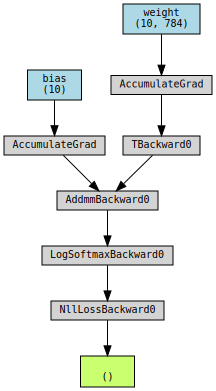

In [45]:
p = make_dot(loss, dict(model.named_parameters()))
p

### Laço de treinamento dos pesos

In [46]:
import numpy
losses = [] #Salvando vetor de perda
zs = [] #Salvando os scores

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()


In [47]:
print('Final loss:', loss.item())

Final loss: 0.265701562166214


### Visualizando gráfico de perda durante o treinamento

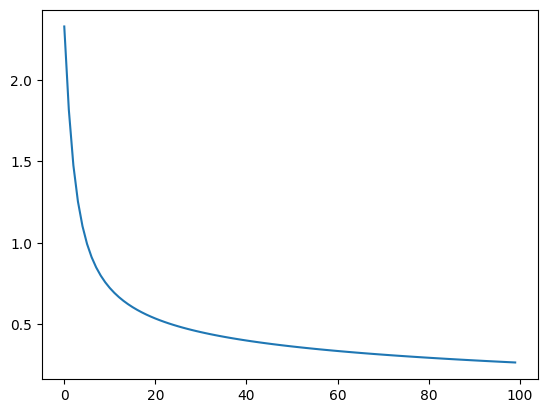

In [48]:
plt.plot(losses) #Imprimindo perdas

## Avaliação

### Acurácia tanto no conjunto de treinamento como no conjunto de testes

In [49]:
def predict(model, input_data):
    outputs = model(Variable(input_data))
    _, predicts = torch.max(outputs, 1)

    return predicts.data

y_pred = predict(model, x_train.view(-1, 28*28))
accuracy = (y_pred.numpy() == y_train.numpy()).mean() #Comparando o pred com o treino
print('Accuracy:', accuracy)

Accuracy: 0.941


### Matriz de confusão com dados de treinamento e teste

In [50]:
print('Matriz de confusão:')
pd.crosstab(y_pred.numpy(), y_train.numpy())

Matriz de confusão:


col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,96,0,1,0,0,0,1,0,0,2
1,0,110,1,0,0,0,1,3,1,0
2,0,1,91,1,0,1,1,1,2,1
3,0,0,0,88,0,2,0,0,0,0
4,0,0,1,0,102,2,0,2,0,3
5,0,2,0,1,0,82,0,0,2,1
6,1,0,1,1,2,2,90,0,0,0
7,0,1,1,1,0,0,0,110,0,3
8,0,2,2,0,0,1,1,0,82,0


## Visualizando a matriz de pesos treinados

Observe que a matriz de peso treinado para cada classe mostra a importância dos pesos associados aos caracteres de cada classe.

weights: torch.Size([10, 784])
bias:    torch.Size([10])


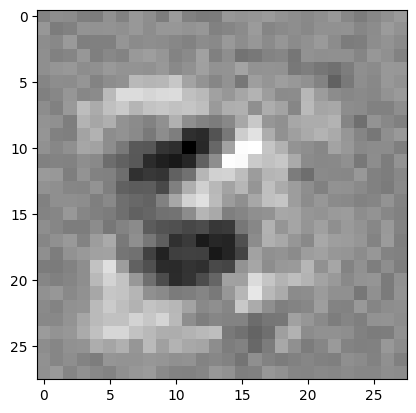

In [51]:
weights = model.state_dict()['weight']
print('weights:', weights.shape)

bias = model.state_dict()['bias']
print('bias:   ', bias.shape)

# Visualizando pesos da classe 3
plt.imshow(weights[3, :].numpy().reshape((28,28)),cmap = 'gray')
plt.show()

### Visualizando os pesos de todas as classes

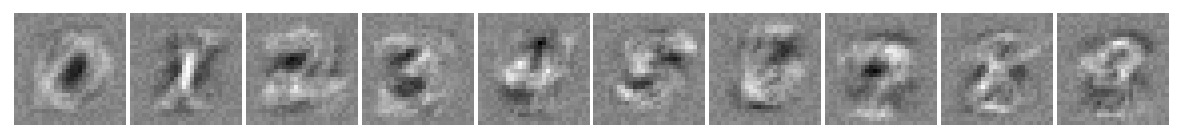

In [52]:
# cria um grid com as imagens
grid = torchvision.utils.make_grid(weights.view(-1, 1, 28, 28), normalize=True, pad_value=1.0, padding=1, nrow=10)

plt.figure(figsize=(15, 10))
plt.imshow(grid.numpy().transpose(1, 2, 0))
plt.axis('off');

### Diagrama da regressão softmax com visualização dos pesos W

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/RegressaoSoftmaxArgmaxNMIST.png)

# Atividades

## Exercícios

- 1) Insira código no laço do treinamento para que no final de cada época,
     seja impresso: o número da época e a perda e a acurácia

In [53]:
#R1

losses = [] #Salvando vetor de perda
zs = [] #Salvando os scores
contador = 0

epoch = 100 #Número de epochs reduzidas para melhor visualização na saída

for i in range(epoch):

    contador = contador + 1


    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    print(contador,loss,accuracy)

1 tensor(0.2644, grad_fn=<NllLossBackward0>) 0.941
2 tensor(0.2630, grad_fn=<NllLossBackward0>) 0.941
3 tensor(0.2617, grad_fn=<NllLossBackward0>) 0.941
4 tensor(0.2604, grad_fn=<NllLossBackward0>) 0.941
5 tensor(0.2592, grad_fn=<NllLossBackward0>) 0.941
6 tensor(0.2579, grad_fn=<NllLossBackward0>) 0.941
7 tensor(0.2567, grad_fn=<NllLossBackward0>) 0.941
8 tensor(0.2554, grad_fn=<NllLossBackward0>) 0.942
9 tensor(0.2542, grad_fn=<NllLossBackward0>) 0.942
10 tensor(0.2530, grad_fn=<NllLossBackward0>) 0.942
11 tensor(0.2518, grad_fn=<NllLossBackward0>) 0.942
12 tensor(0.2506, grad_fn=<NllLossBackward0>) 0.944
13 tensor(0.2495, grad_fn=<NllLossBackward0>) 0.944
14 tensor(0.2483, grad_fn=<NllLossBackward0>) 0.945
15 tensor(0.2472, grad_fn=<NllLossBackward0>) 0.945
16 tensor(0.2460, grad_fn=<NllLossBackward0>) 0.945
17 tensor(0.2449, grad_fn=<NllLossBackward0>) 0.945
18 tensor(0.2438, grad_fn=<NllLossBackward0>) 0.946
19 tensor(0.2427, grad_fn=<NllLossBackward0>) 0.946
20 tensor(0.2416, gra

- 2) Insira código no laço do treinamento para visualização dos valores dos gradientes referentes à classe do dígito 4, no final de cada época.

epoch:  1 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1340, grad_fn=<NllLossBackward0>) ,Precisão:  0.978


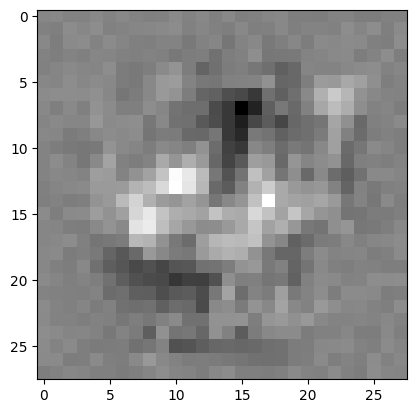

epoch:  2 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1337, grad_fn=<NllLossBackward0>) ,Precisão:  0.978


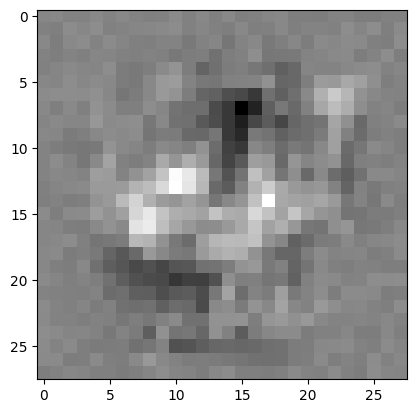

epoch:  3 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1334, grad_fn=<NllLossBackward0>) ,Precisão:  0.978


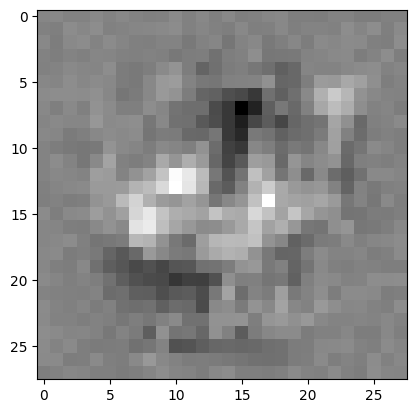

epoch:  4 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1330, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


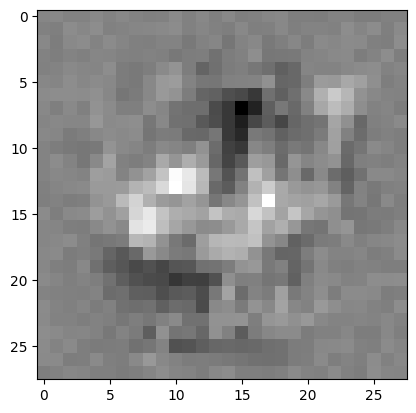

epoch:  5 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1327, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


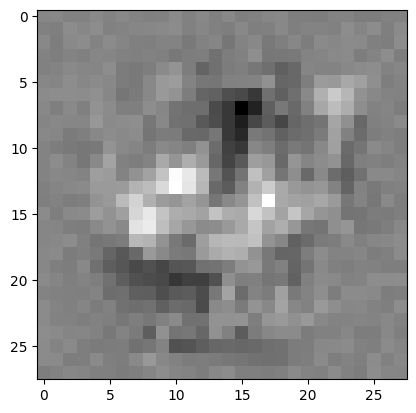

epoch:  6 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1324, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


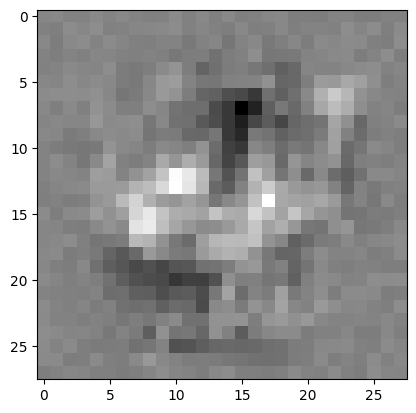

epoch:  7 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1320, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


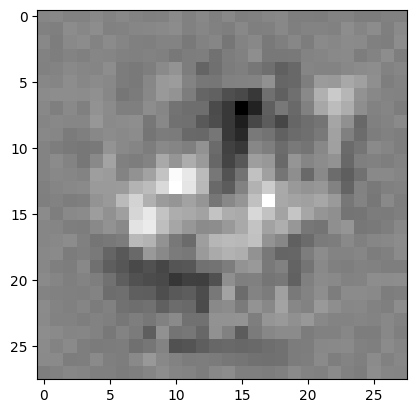

epoch:  8 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1317, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


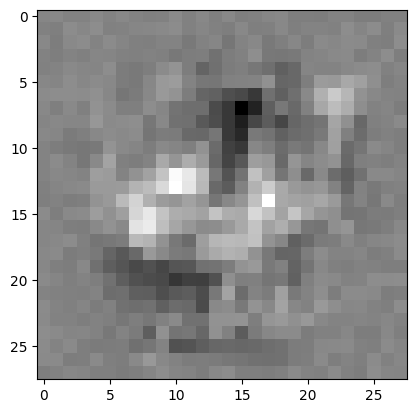

epoch:  9 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1314, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


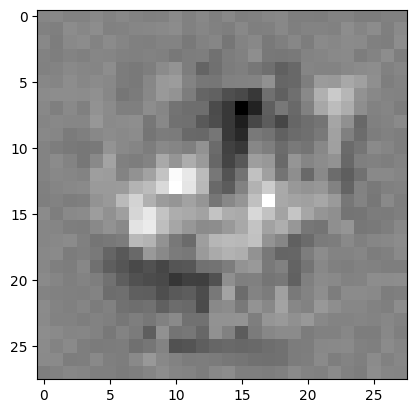

epoch:  10 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1310, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


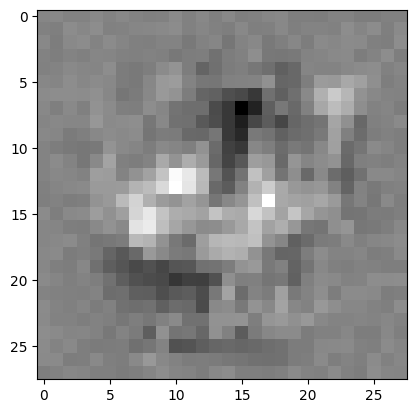

epoch:  11 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1307, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


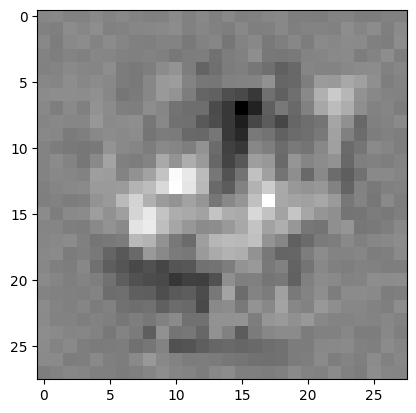

epoch:  12 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1304, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


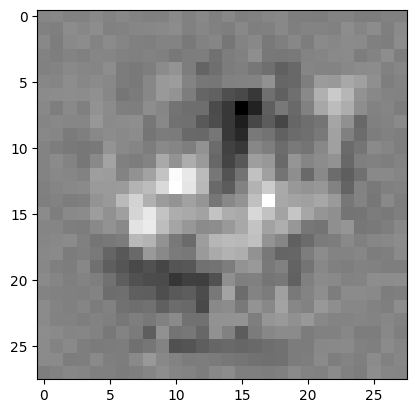

epoch:  13 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1301, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


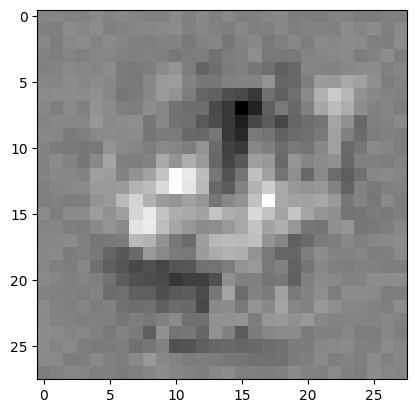

epoch:  14 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1297, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


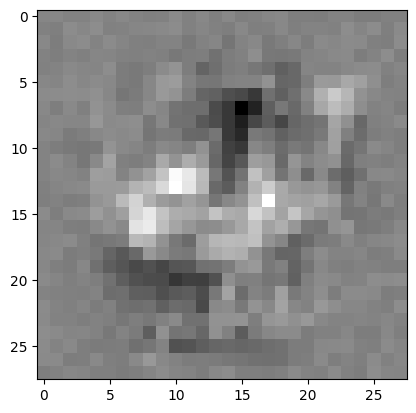

epoch:  15 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1294, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


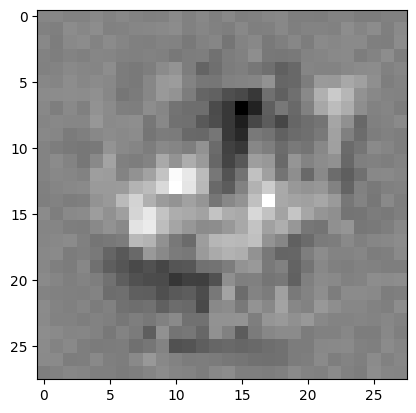

epoch:  16 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1291, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


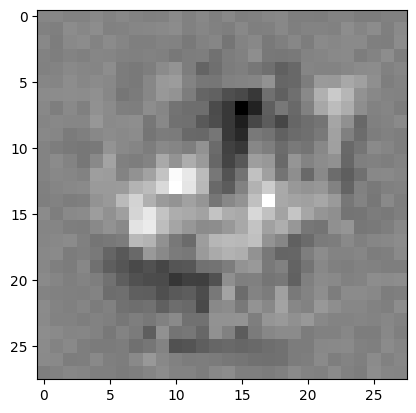

epoch:  17 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1288, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


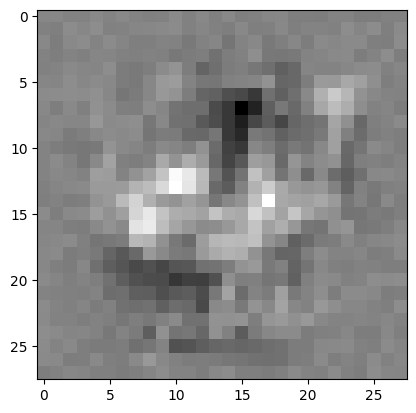

epoch:  18 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1285, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


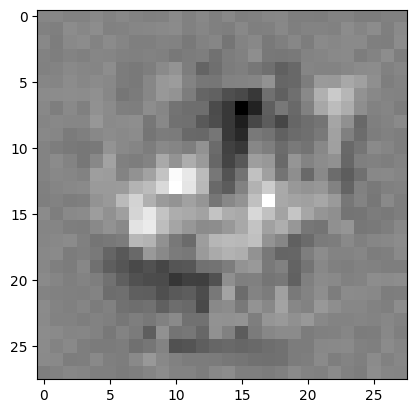

epoch:  19 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1282, grad_fn=<NllLossBackward0>) ,Precisão:  0.979


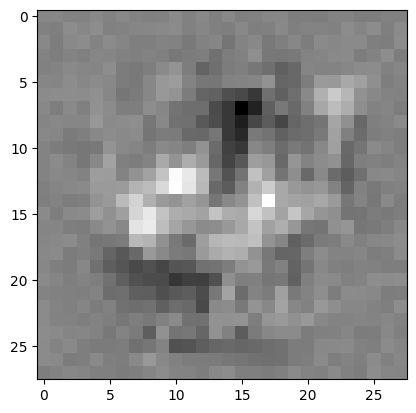

epoch:  20 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1279, grad_fn=<NllLossBackward0>) ,Precisão:  0.98


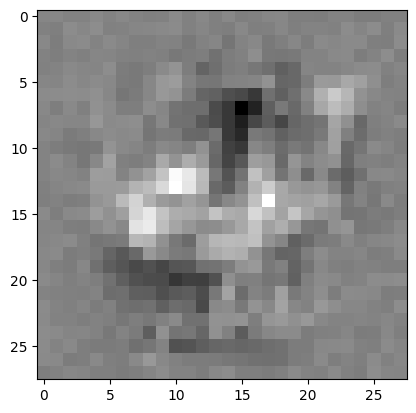

epoch:  21 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1275, grad_fn=<NllLossBackward0>) ,Precisão:  0.98


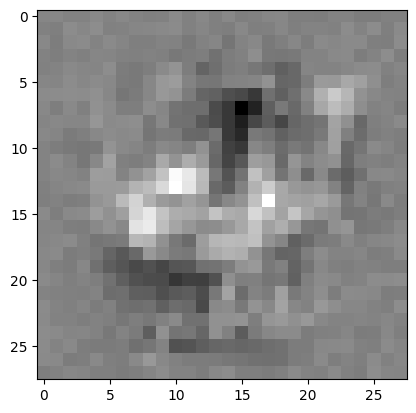

epoch:  22 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1272, grad_fn=<NllLossBackward0>) ,Precisão:  0.98


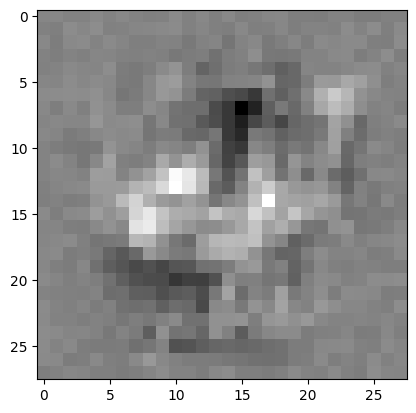

epoch:  23 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1269, grad_fn=<NllLossBackward0>) ,Precisão:  0.98


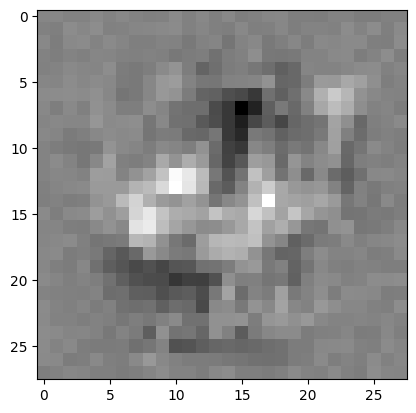

epoch:  24 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1266, grad_fn=<NllLossBackward0>) ,Precisão:  0.98


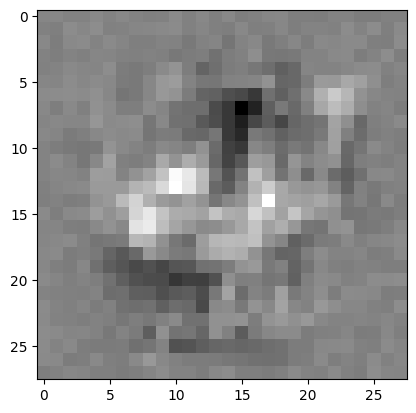

epoch:  25 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1263, grad_fn=<NllLossBackward0>) ,Precisão:  0.98


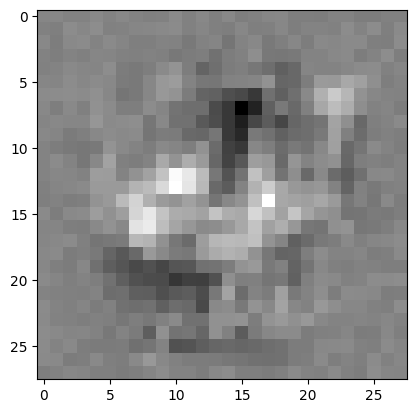

epoch:  26 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1260, grad_fn=<NllLossBackward0>) ,Precisão:  0.981


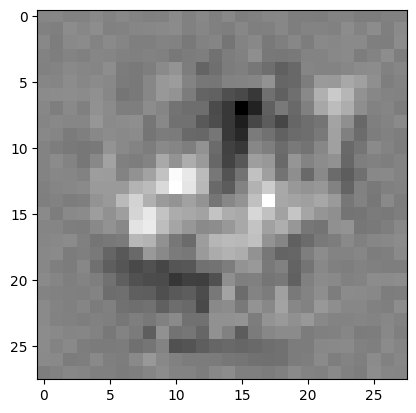

epoch:  27 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1257, grad_fn=<NllLossBackward0>) ,Precisão:  0.981


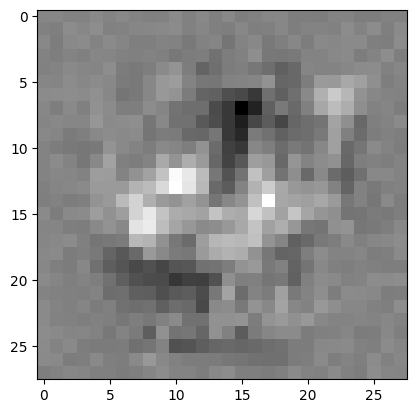

epoch:  28 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1254, grad_fn=<NllLossBackward0>) ,Precisão:  0.981


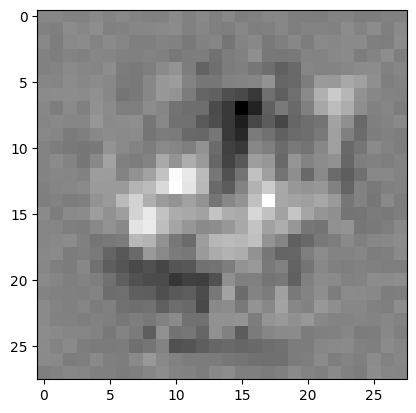

epoch:  29 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1251, grad_fn=<NllLossBackward0>) ,Precisão:  0.982


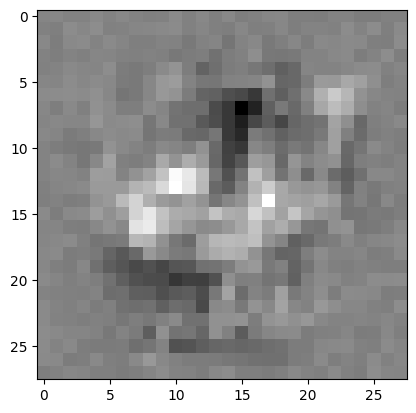

epoch:  30 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1248, grad_fn=<NllLossBackward0>) ,Precisão:  0.982


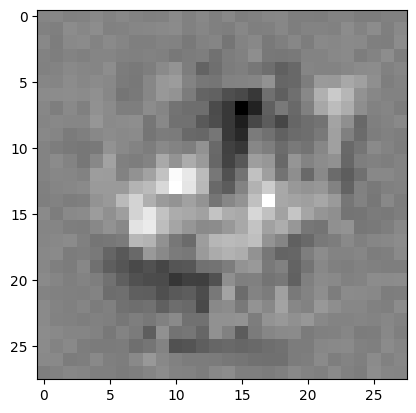

epoch:  31 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1245, grad_fn=<NllLossBackward0>) ,Precisão:  0.982


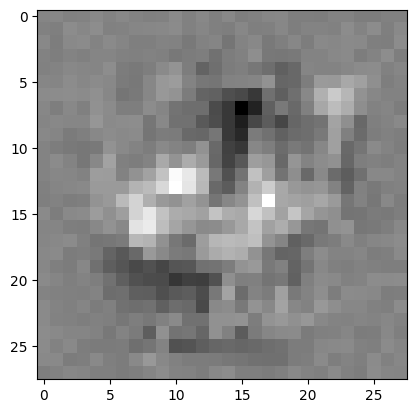

epoch:  32 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1242, grad_fn=<NllLossBackward0>) ,Precisão:  0.982


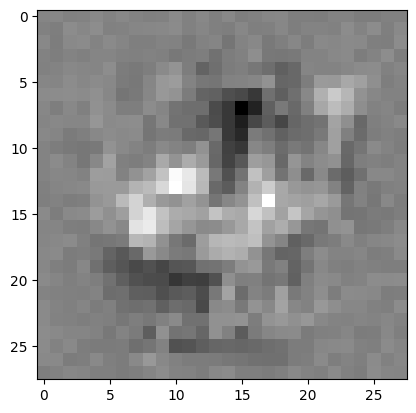

epoch:  33 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1239, grad_fn=<NllLossBackward0>) ,Precisão:  0.983


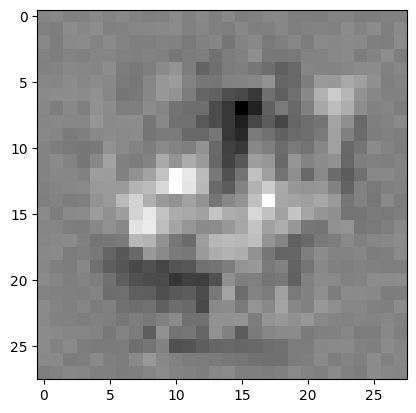

epoch:  34 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1236, grad_fn=<NllLossBackward0>) ,Precisão:  0.983


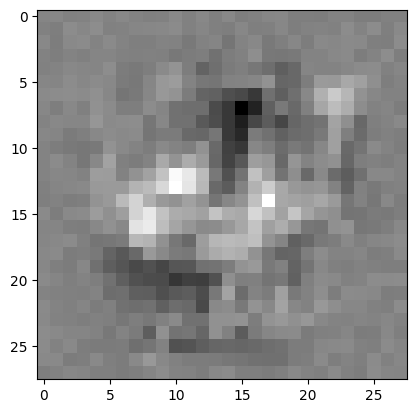

epoch:  35 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1233, grad_fn=<NllLossBackward0>) ,Precisão:  0.983


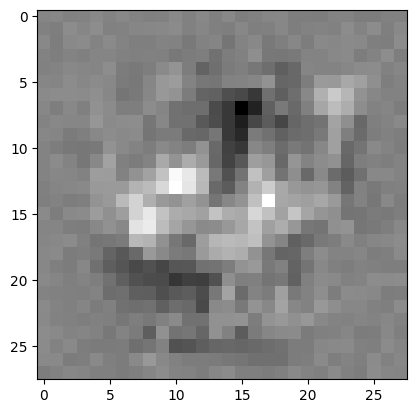

epoch:  36 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1230, grad_fn=<NllLossBackward0>) ,Precisão:  0.983


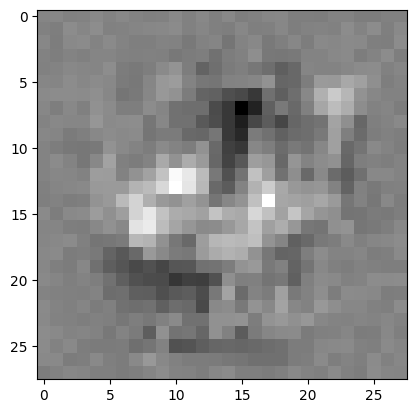

epoch:  37 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1227, grad_fn=<NllLossBackward0>) ,Precisão:  0.983


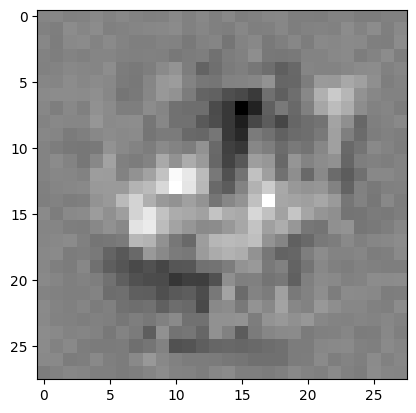

epoch:  38 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1224, grad_fn=<NllLossBackward0>) ,Precisão:  0.983


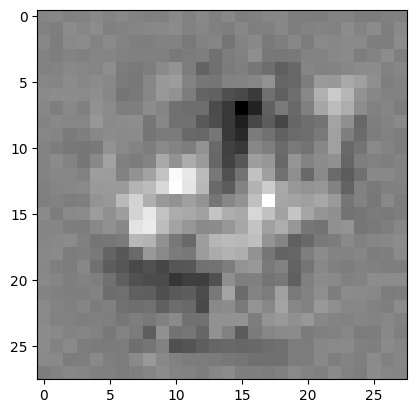

epoch:  39 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1222, grad_fn=<NllLossBackward0>) ,Precisão:  0.983


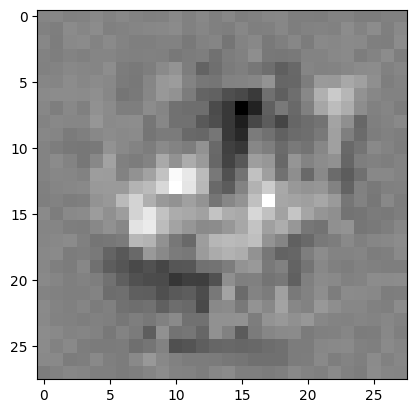

epoch:  40 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1219, grad_fn=<NllLossBackward0>) ,Precisão:  0.983


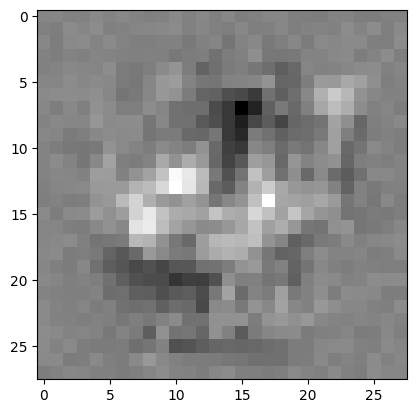

epoch:  41 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1216, grad_fn=<NllLossBackward0>) ,Precisão:  0.984


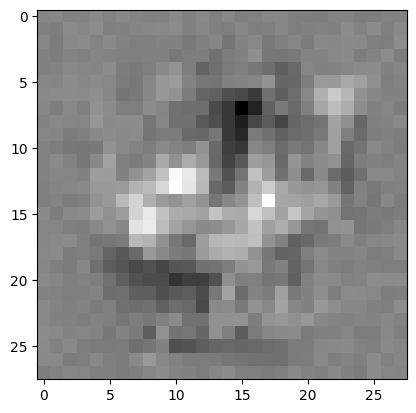

epoch:  42 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1213, grad_fn=<NllLossBackward0>) ,Precisão:  0.984


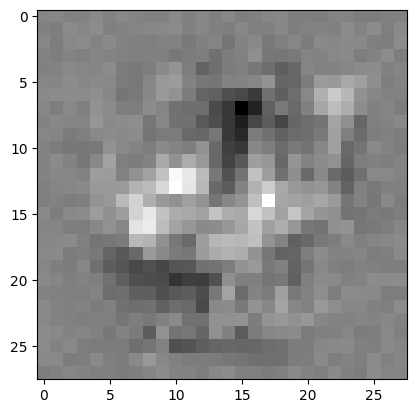

epoch:  43 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1210, grad_fn=<NllLossBackward0>) ,Precisão:  0.984


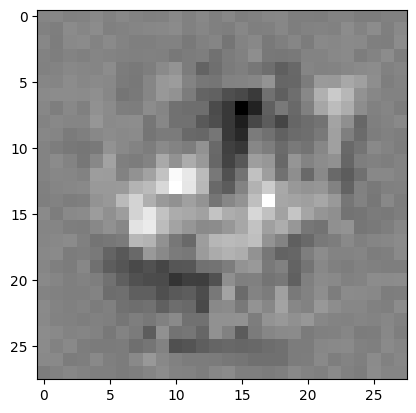

epoch:  44 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1207, grad_fn=<NllLossBackward0>) ,Precisão:  0.984


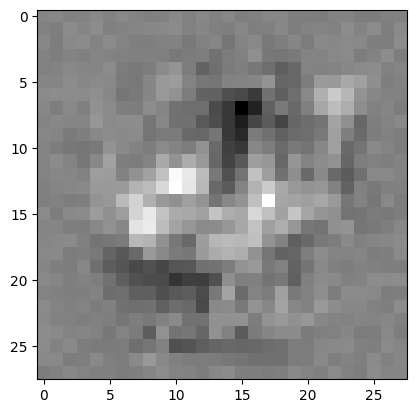

epoch:  45 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1204, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


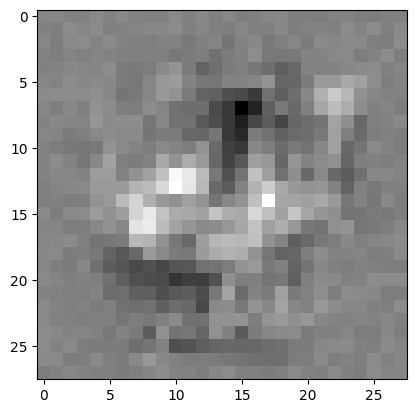

epoch:  46 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1202, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


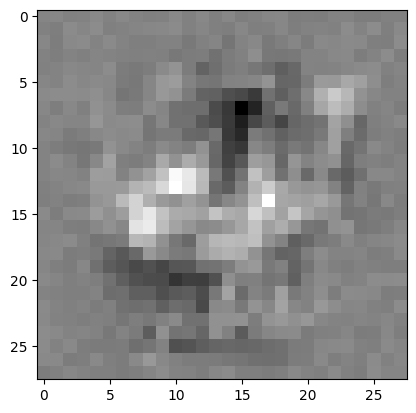

epoch:  47 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1199, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


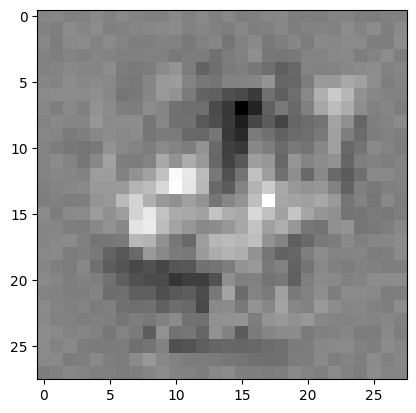

epoch:  48 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1196, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


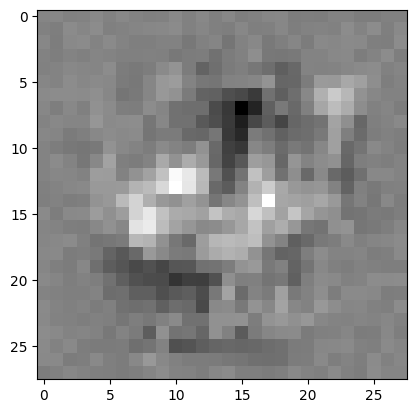

epoch:  49 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1193, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


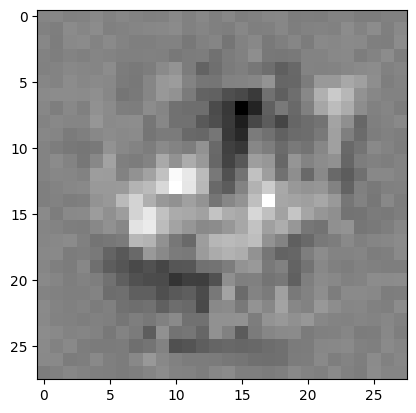

epoch:  50 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1191, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


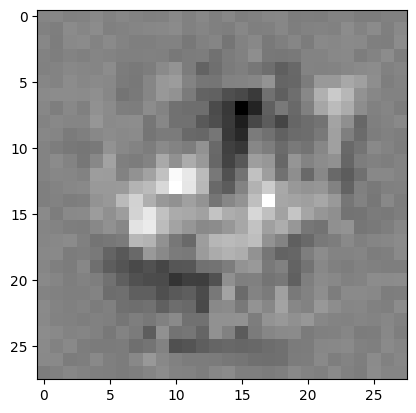

epoch:  51 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1188, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


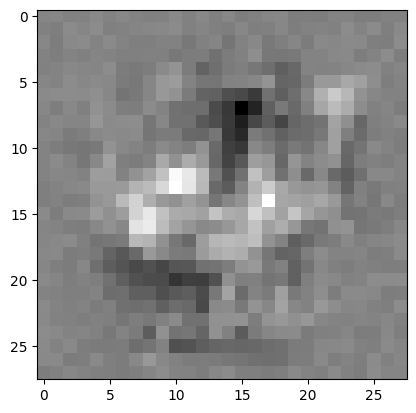

epoch:  52 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1185, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


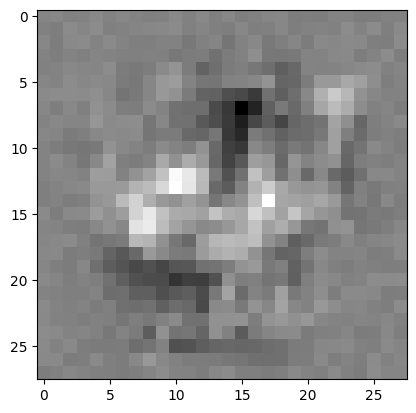

epoch:  53 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1182, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


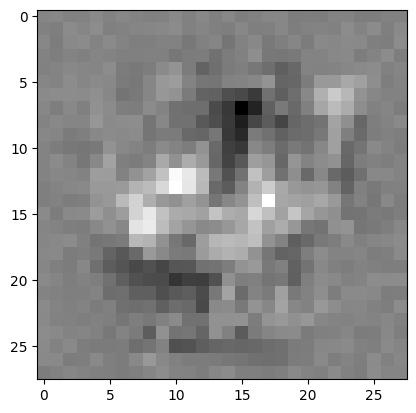

epoch:  54 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1180, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


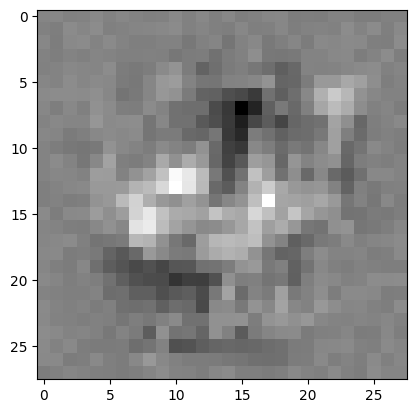

epoch:  55 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1177, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


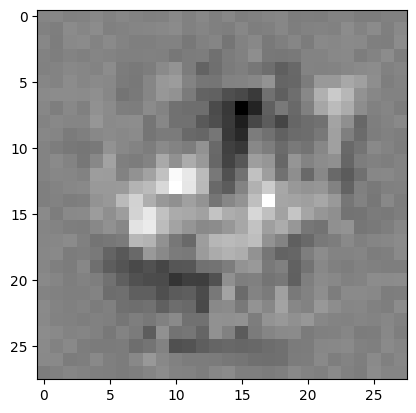

epoch:  56 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1174, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


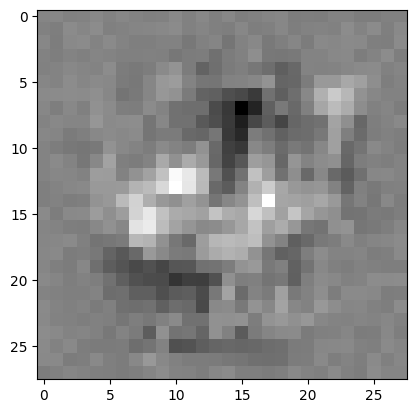

epoch:  57 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1172, grad_fn=<NllLossBackward0>) ,Precisão:  0.985


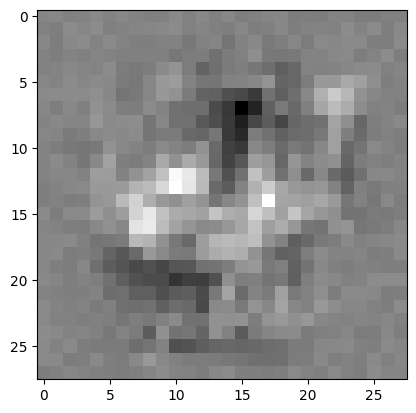

epoch:  58 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1169, grad_fn=<NllLossBackward0>) ,Precisão:  0.986


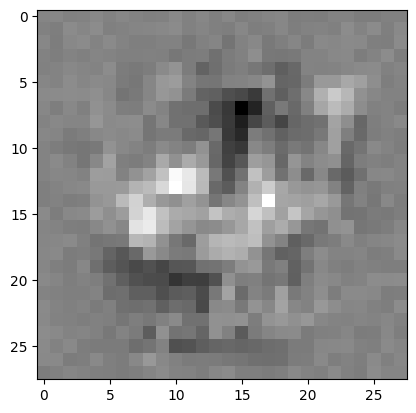

epoch:  59 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1166, grad_fn=<NllLossBackward0>) ,Precisão:  0.986


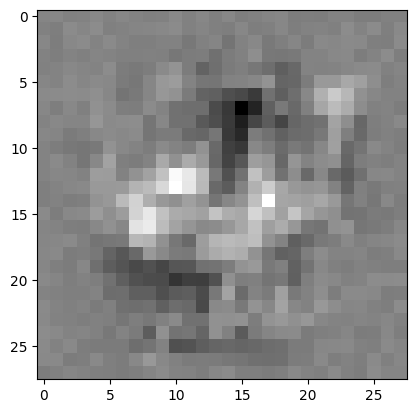

epoch:  60 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1164, grad_fn=<NllLossBackward0>) ,Precisão:  0.987


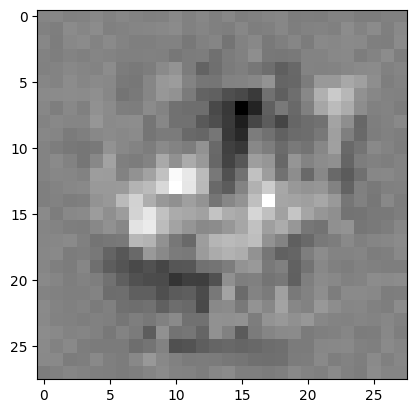

epoch:  61 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1161, grad_fn=<NllLossBackward0>) ,Precisão:  0.987


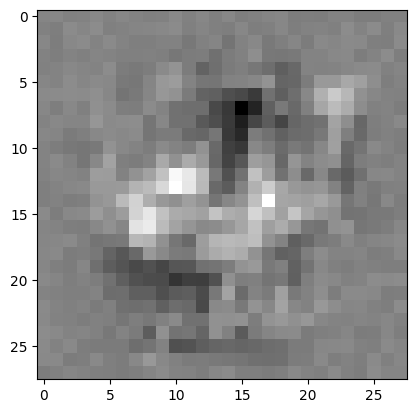

epoch:  62 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1158, grad_fn=<NllLossBackward0>) ,Precisão:  0.987


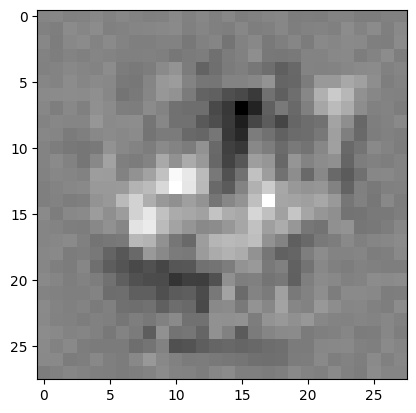

epoch:  63 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1156, grad_fn=<NllLossBackward0>) ,Precisão:  0.987


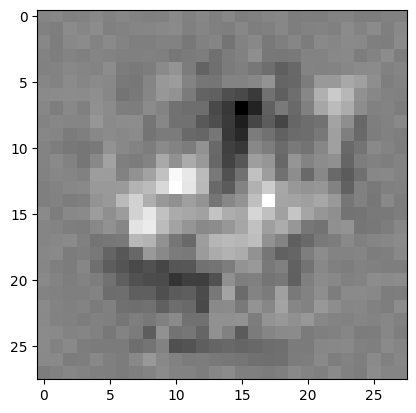

epoch:  64 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1153, grad_fn=<NllLossBackward0>) ,Precisão:  0.988


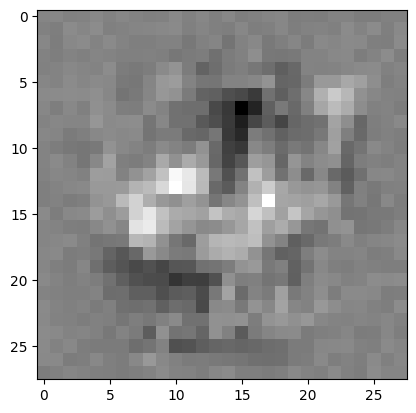

epoch:  65 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1151, grad_fn=<NllLossBackward0>) ,Precisão:  0.988


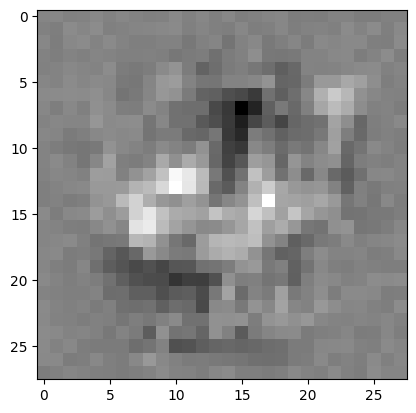

epoch:  66 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1148, grad_fn=<NllLossBackward0>) ,Precisão:  0.988


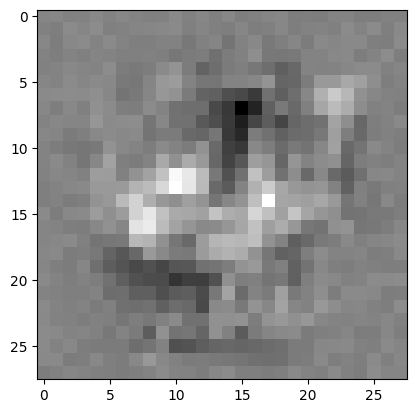

epoch:  67 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1145, grad_fn=<NllLossBackward0>) ,Precisão:  0.988


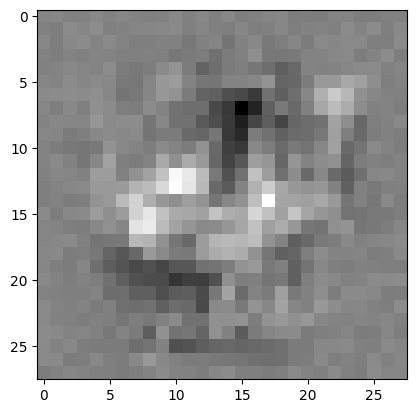

epoch:  68 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1143, grad_fn=<NllLossBackward0>) ,Precisão:  0.988


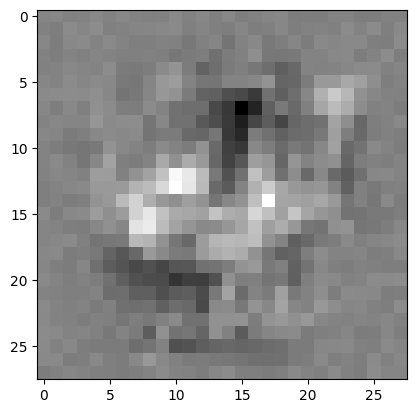

epoch:  69 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1140, grad_fn=<NllLossBackward0>) ,Precisão:  0.988


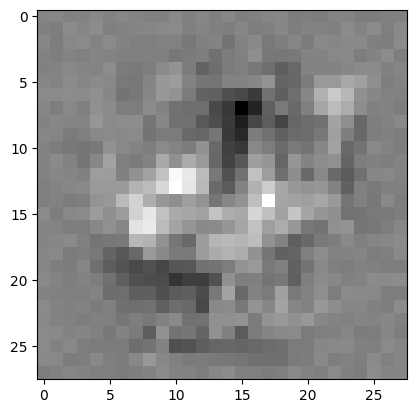

epoch:  70 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1138, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


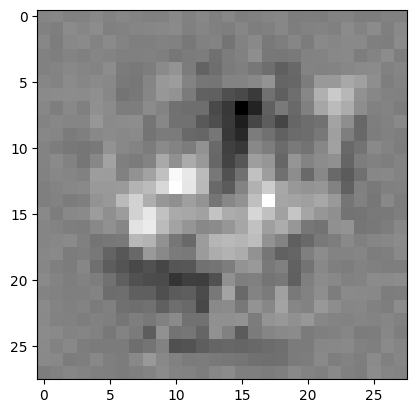

epoch:  71 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1135, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


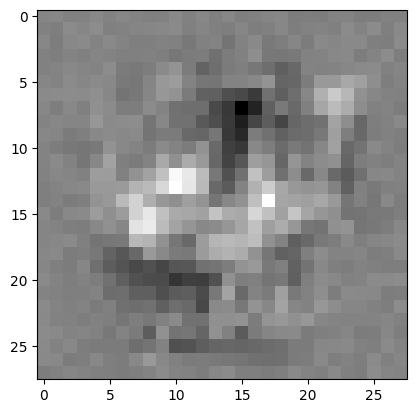

epoch:  72 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1133, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


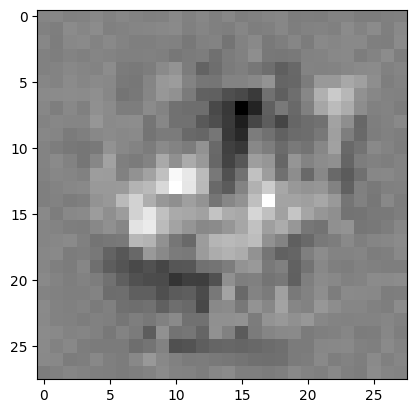

epoch:  73 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1130, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


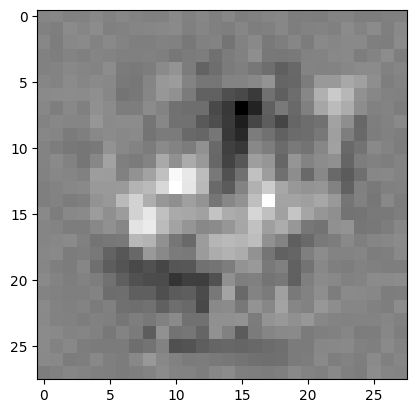

epoch:  74 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1128, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


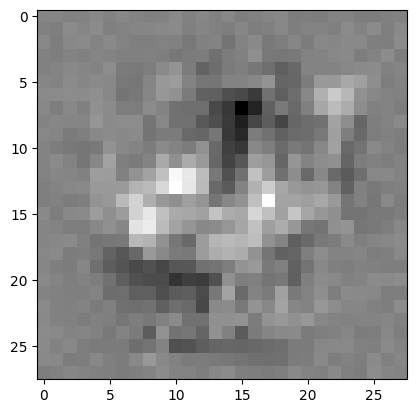

epoch:  75 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1125, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


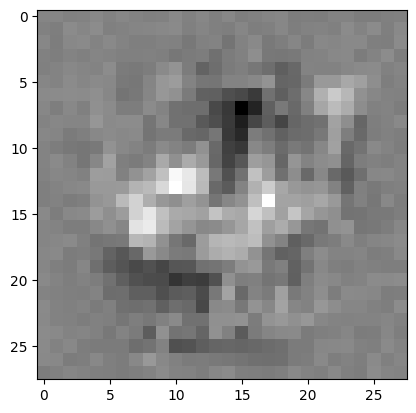

epoch:  76 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1123, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


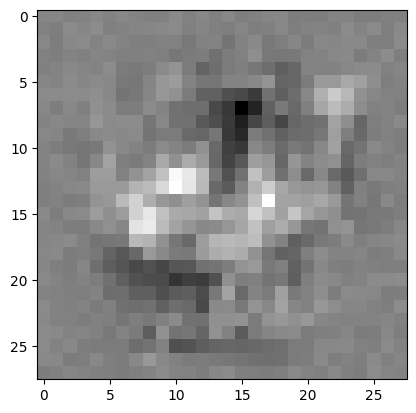

epoch:  77 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1120, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


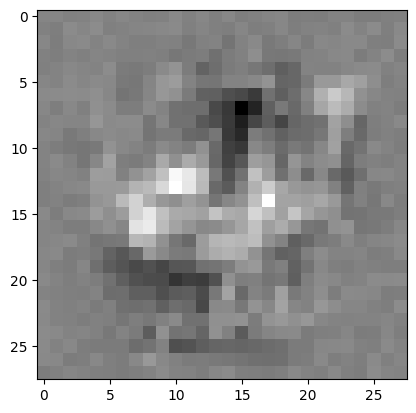

epoch:  78 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1118, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


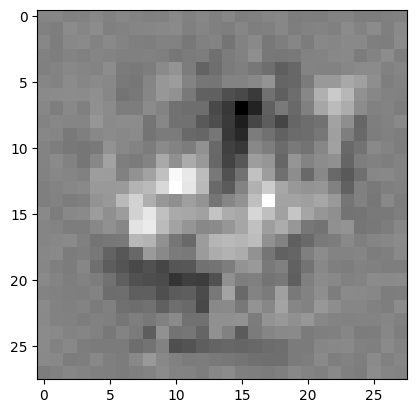

epoch:  79 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1115, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


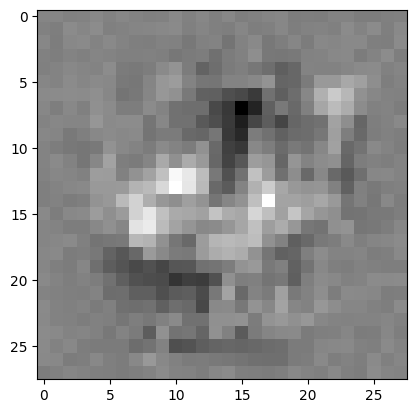

epoch:  80 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1113, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


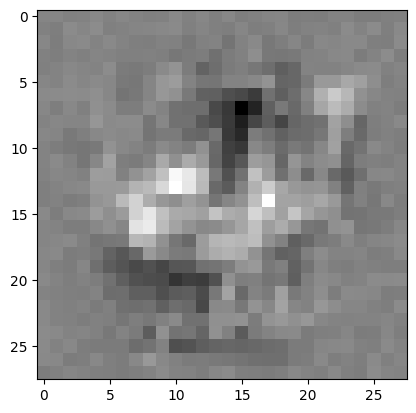

epoch:  81 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1111, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


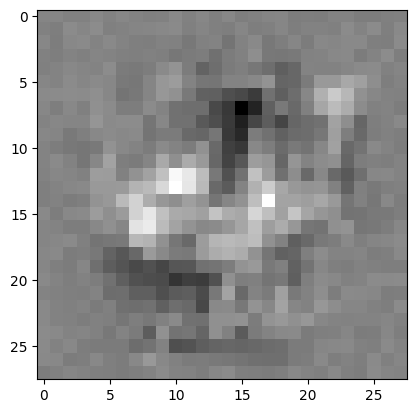

epoch:  82 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1108, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


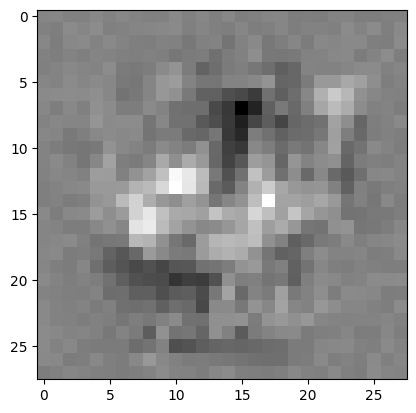

epoch:  83 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1106, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


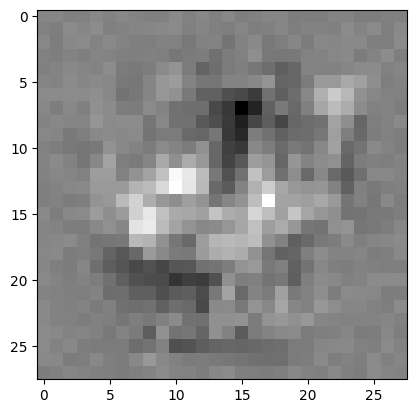

epoch:  84 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1103, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


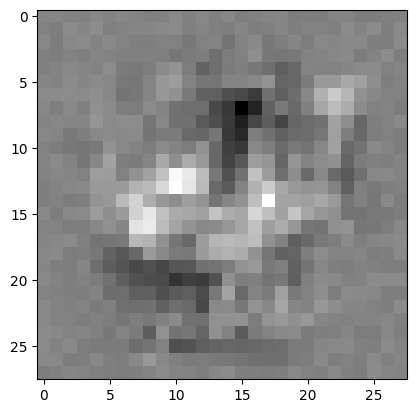

epoch:  85 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1101, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


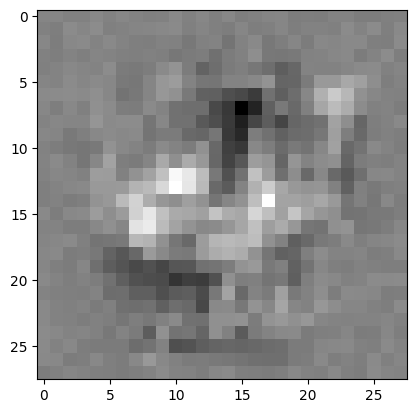

epoch:  86 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1099, grad_fn=<NllLossBackward0>) ,Precisão:  0.989


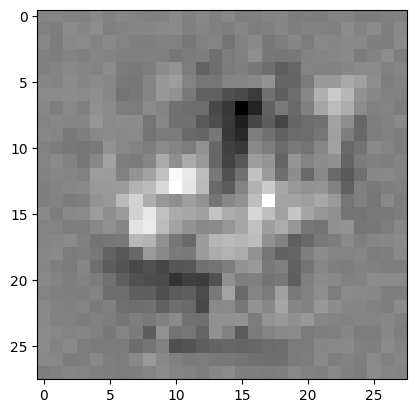

epoch:  87 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1096, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


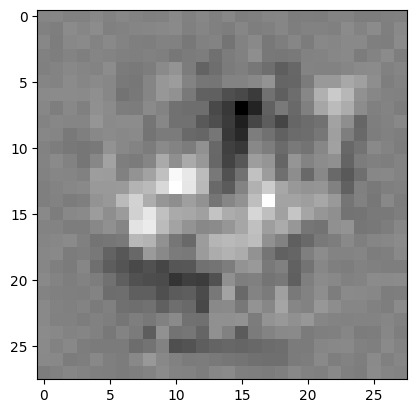

epoch:  88 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1094, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


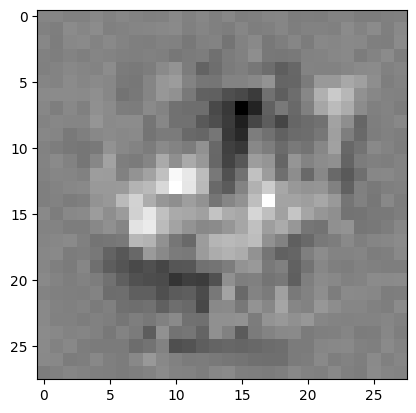

epoch:  89 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1091, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


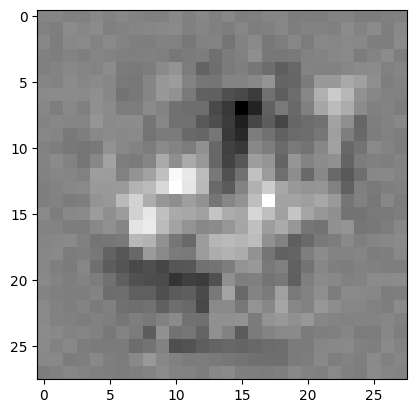

epoch:  90 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1089, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


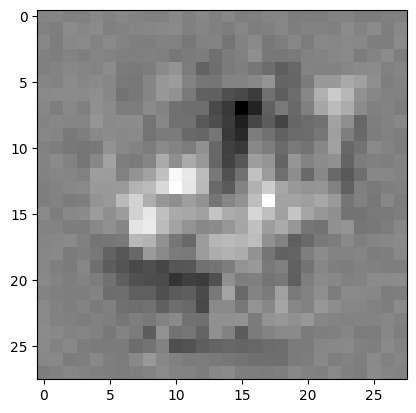

epoch:  91 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1087, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


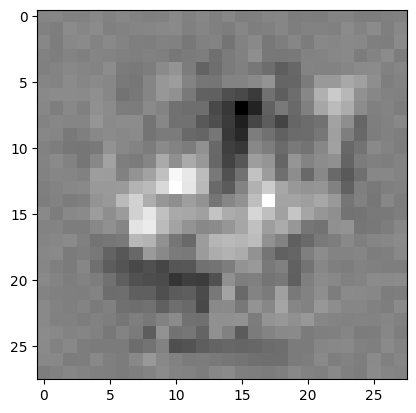

epoch:  92 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1084, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


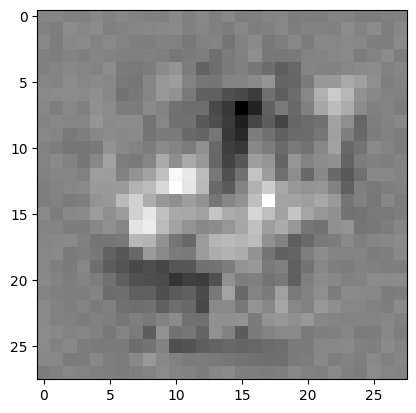

epoch:  93 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1082, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


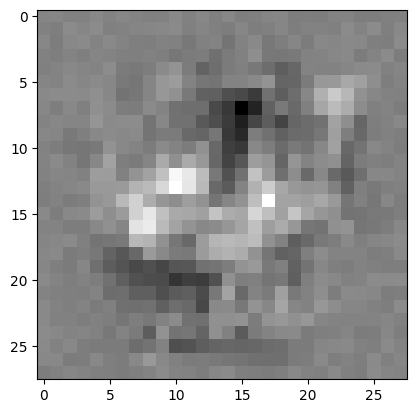

epoch:  94 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1080, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


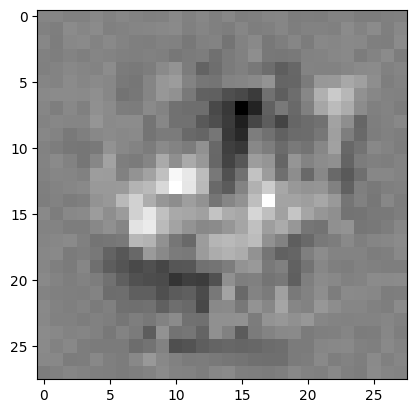

epoch:  95 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1078, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


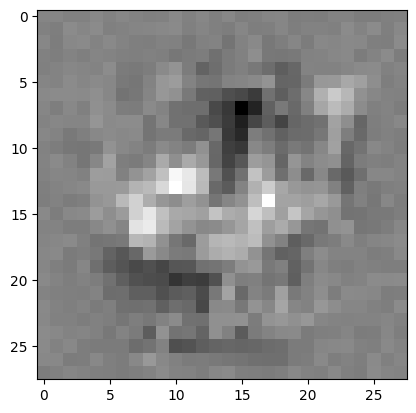

epoch:  96 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1075, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


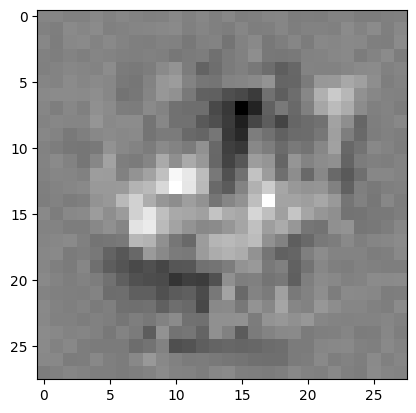

epoch:  97 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1073, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


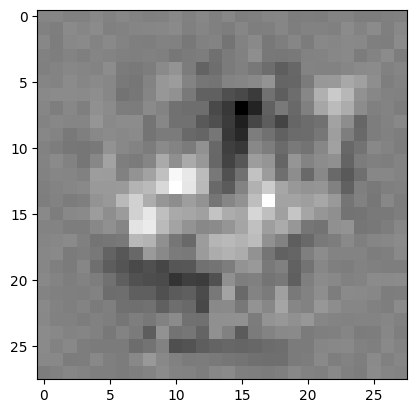

epoch:  98 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1071, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


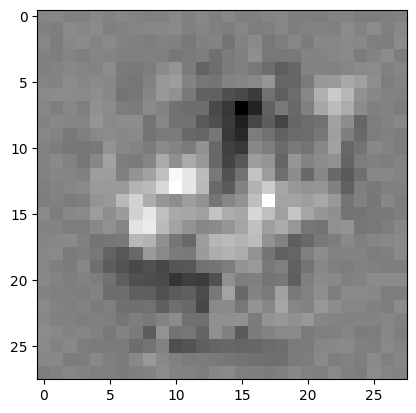

epoch:  99 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1068, grad_fn=<NllLossBackward0>) ,Precisão:  0.99


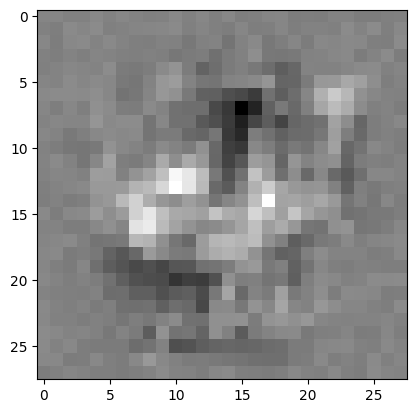

epoch:  100 ,bias:  torch.Size([10]) ,weights:  torch.Size([10, 784]) ,Perda:  tensor(0.1066, grad_fn=<NllLossBackward0>) ,Precisão:  0.991


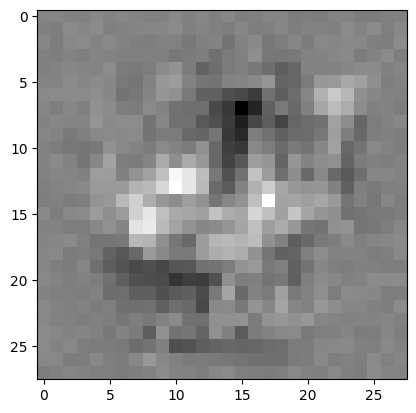

In [55]:
#R2

losses = [] #Salvando vetor de perda
zs = [] #Salvando os scores
contador = 0

epoch = 100 #Número de epochs reduzidas para melhor visualização na saída

for i in range(epoch):

    contador = contador + 1


    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)

    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    _, predicts = torch.max(outputs, 1)

    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()

    weights = model.state_dict()['weight']
    bias = model.state_dict()['bias']

    print ('epoch: ',contador ,',bias: ', bias.shape, ',weights: ', weights.shape,',Perda: ',loss,',Precisão: ',accuracy)
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()


<details>
<summary>Mostrar Resultado</summary>

```python
losses = []
import numpy

import numpy
zs = []

for i in range(epochs):
    # Transforma a entrada para uma dimensão
    inputs = Variable(x_train.view(-1, 28 * 28))
    # Predict da rede
    outputs = model(inputs)
    
    # z0 a z9
    zs.append(outputs[1].detach().numpy())

    # calcula a perda
    loss = criterion(outputs, Variable(y_train))

    # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    _, predicts = torch.max(outputs, 1)
    
    y_pred = predicts.data
    accuracy = (y_pred.numpy() == y_train.numpy()).mean()
    
    print('Epoch[{}/{}], loss: {:.6f}, acc: {:.6f}'
              .format(i+1, epochs, loss.data, accuracy))
    
    weights = model.state_dict()['weight']
    print('weights:', weights.shape)

    bias = model.state_dict()['bias']
    print('bias:   ', bias.shape)

    # Visualizando pesos da classe 3
    plt.imshow(weights[4, :].numpy().reshape((28,28)),cmap = 'gray')
    plt.show()
```

</details>

## Perguntas

1. Qual é o shape da matriz de entrada na rede?

R: 1000, 28, 28 entrada
   

2. Qual é o shape da saída da rede?

R: 1000, 10 Saídas


3. Qual é o número total de parâmetros da rede, incluindo o bias?

R:20x20x10 + 10 = 7850

# Aprendizados
